In [1]:
from numpy import *
import matplotlib.pyplot as plt

In [2]:
def loadSimpData():
    datMat = matrix([[ 1. ,  2.1],
        [ 2. ,  1.1],
        [ 1.3,  1. ],
        [ 1. ,  1. ],
        [ 2. ,  1. ]])
    classLabels = [1.0, 1.0, -1.0, -1.0, 1.0]
    return datMat,classLabels

def loadDataSet(fileName):      #general function to parse tab -delimited floats
    numFeat = len(open(fileName).readline().split('\t')) #get number of fields 
    dataMat = []; labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr =[]
        curLine = line.strip().split('\t')
        for i in range(numFeat-1):
            lineArr.append(float(curLine[i]))
        dataMat.append(lineArr)
        labelMat.append(float(curLine[-1]))
    return dataMat,labelMat

def stumpClassify(dataMatrix,dimen,threshVal,threshIneq):#just classify the data
    retArray = ones((shape(dataMatrix)[0],1))
    if threshIneq == 'lt':
        retArray[dataMatrix[:,dimen] <= threshVal] = -1.0
    else:
        retArray[dataMatrix[:,dimen] > threshVal] = -1.0
    return retArray
    

def buildStump(dataArr,classLabels,D):
    dataMatrix = mat(dataArr); labelMat = mat(classLabels).T
    m,n = shape(dataMatrix)
    numSteps = 10.0; 
    bestStump = {}; 
    bestClasEst = mat(zeros((m,1)))
    minError = inf #init error sum, to +infinity
    for i in range(n):#loop over all dimensions
        rangeMin = dataMatrix[:,i].min(); rangeMax = dataMatrix[:,i].max();
        stepSize = (rangeMax-rangeMin)/numSteps
        for j in range(-1,int(numSteps)+1):#loop over all range in current dimension
            for inequal in ['lt', 'gt']: #go over less than and greater than
                threshVal = (rangeMin + float(j) * stepSize)
                predictedVals = stumpClassify(dataMatrix,i,threshVal,inequal)#call stump classify with i, j, lessThan
                errArr = mat(ones((m,1)))
                errArr[predictedVals == labelMat] = 0
                weightedError = D.T*errArr  #calc total error multiplied by D
                #print("split: dim %d, thresh %.2f, thresh ineqal: %s, the weighted error is %.3f" % (i, threshVal, inequal, weightedError))
                if weightedError < minError:
                    minError = weightedError
                    bestClasEst = predictedVals.copy()
                    bestStump['dim'] = i
                    bestStump['thresh'] = threshVal
                    bestStump['ineq'] = inequal
    return bestStump,minError,bestClasEst


def adaBoostTrainDS(dataArr,classLabels,numIt=40):
    weakClassArr = []
    m = shape(dataArr)[0]
    D = mat(ones((m,1))/m)   #init D to all equal
    aggClassEst = mat(zeros((m,1)))
    for i in range(numIt):
        bestStump,error,classEst = buildStump(dataArr,classLabels,D)#build Stump
        #print "D:",D.T
        alpha = float(0.5*log((1.0-error)/max(error,1e-16)))#calc alpha, throw in max(error,eps) to account for error=0
        bestStump['alpha'] = alpha  
        weakClassArr.append(bestStump)                  #store Stump Params in Array
        #print "classEst: ",classEst.T
        expon = multiply(-1*alpha*mat(classLabels).T,classEst) #exponent for D calc, getting messy
        D = multiply(D,exp(expon))                              #Calc New D for next iteration
        D = D/D.sum()
        #calc training error of all classifiers, if this is 0 quit for loop early (use break)
        aggClassEst += alpha*classEst
        print("aggClassEst: ",aggClassEst.T)
        aggErrors = multiply(sign(aggClassEst) != mat(classLabels).T,ones((m,1)))
        errorRate = aggErrors.sum()/m
        print("total error: ",errorRate)
        if errorRate == 0.0: 
            break
    return weakClassArr,aggClassEst

def adaClassify(datToClass,classifierArr):
    dataMatrix = mat(datToClass)#do stuff similar to last aggClassEst in adaBoostTrainDS
    m = shape(dataMatrix)[0]
    aggClassEst = mat(zeros((m,1)))
    for i in range(len(classifierArr)):
        classEst = stumpClassify(dataMatrix,classifierArr[i]['dim'],\
                                 classifierArr[i]['thresh'],\
                                 classifierArr[i]['ineq'])#call stump classify
        aggClassEst += classifierArr[i]['alpha']*classEst
        #print(aggClassEst)
    return sign(aggClassEst)

def plotROC(predStrengths, classLabels):
    import matplotlib.pyplot as plt
    cur = (1.0,1.0) #cursor
    ySum = 0.0 #variable to calculate AUC
    numPosClas = sum(array(classLabels)==1.0)
    yStep = 1/float(numPosClas); xStep = 1/float(len(classLabels)-numPosClas)
    sortedIndicies = predStrengths.argsort()#get sorted index, it's reverse
    fig = plt.figure()
    fig.clf()
    ax = plt.subplot(111)
    #loop through all the values, drawing a line segment at each point
    for index in sortedIndicies.tolist()[0]:
        if classLabels[index] == 1.0:
            delX = 0; delY = yStep;
        else:
            delX = xStep; delY = 0;
            ySum += cur[1]
        #draw line from cur to (cur[0]-delX,cur[1]-delY)
        ax.plot([cur[0],cur[0]-delX],[cur[1],cur[1]-delY], c='b')
        cur = (cur[0]-delX,cur[1]-delY)
    ax.plot([0,1],[0,1],'b--')
    plt.xlabel('False positive rate'); plt.ylabel('True positive rate')
    plt.title('ROC curve for AdaBoost horse colic detection system')
    ax.axis([0,1,0,1])
    plt.show()
    print("the Area Under the Curve is: ",ySum*xStep)

aggClassEst:  [[-0.46166238  0.46166238  0.46166238  0.46166238  0.46166238  0.46166238
   0.46166238  0.46166238 -0.46166238 -0.46166238  0.46166238  0.46166238
   0.46166238  0.46166238  0.46166238 -0.46166238 -0.46166238  0.46166238
   0.46166238  0.46166238 -0.46166238  0.46166238  0.46166238  0.46166238
   0.46166238  0.46166238  0.46166238  0.46166238  0.46166238  0.46166238
  -0.46166238  0.46166238  0.46166238  0.46166238 -0.46166238 -0.46166238
   0.46166238 -0.46166238  0.46166238  0.46166238 -0.46166238  0.46166238
   0.46166238 -0.46166238 -0.46166238 -0.46166238 -0.46166238  0.46166238
   0.46166238 -0.46166238  0.46166238  0.46166238  0.46166238  0.46166238
   0.46166238  0.46166238  0.46166238 -0.46166238 -0.46166238 -0.46166238
   0.46166238  0.46166238  0.46166238  0.46166238  0.46166238  0.46166238
   0.46166238  0.46166238  0.46166238  0.46166238  0.46166238  0.46166238
   0.46166238 -0.46166238  0.46166238  0.46166238  0.46166238  0.46166238
  -0.46166238  0.4616623

aggClassEst:  [[-0.77989548  0.67233872  1.05074203  0.08364361 -0.56421145  1.35528941
   1.09400649  0.71492962 -0.53513377  0.16856261  0.4047122   0.72755432
   1.39855387  0.78166995  1.18086971 -0.53513377 -1.16009867  0.69415858
   0.47712257 -0.54132129 -0.15817602  1.66550683  1.30117378  1.23298788
   0.60369933  0.37097086  0.38819099  0.9840017   0.69415858  1.82689954
  -1.16009867  0.10016482  0.8249344   0.78733999 -0.53513377 -1.7150778
  -0.1896783  -0.56573353  1.36095945  0.37097086 -1.7150778   0.37097086
   0.10016482 -0.62417281 -0.67763736 -1.7150778  -1.41053042  1.36095945
  -0.23677391 -1.19769309  1.05074203  0.72755432  1.05074203  0.69415858
   0.0734435   0.13775924  0.69415858 -0.15817602 -0.83691096 -1.7150778
   1.30117378  1.09188737 -0.23937187 -0.32581295  0.35059657  0.81653666
   0.31809776  1.66550683  0.33424759  1.36095945  0.05189973  1.66550683
   0.12053912 -0.19300025  0.69415858  0.10016482  1.4499418   1.82689954
  -0.21194605  0.15670505 

aggClassEst:  [[-0.50355487  0.42735981  1.04343778 -0.14968212 -0.35457715  1.30497027
   1.04661191  0.42693582 -0.78303724  0.64248755  0.15203225  0.72025006
   1.35115929  0.56908033  0.9358908  -0.48481463 -1.42873825  0.68685433
   0.23214366 -0.33168699 -0.11951007  1.65050154  1.05619487  1.20494752
   0.35101938  0.36366661  0.14321208  0.93660712  0.40616478  2.01717962
  -0.87210488  0.30209809  0.77753982  0.54236108 -0.52012848 -1.74604272
   0.21754033 -0.32948324  1.55123953  0.34293051 -1.71942673  0.58060516
   0.2904449  -0.69522805 -0.94627694 -1.26481352 -1.17428013  1.55123953
  -0.68703819 -1.20499734  1.24102211  0.48257541  1.00042289  0.68685433
   0.07779243  0.10971888  0.40616478 -0.36010929 -1.03884422 -1.26481352
   1.29386953  1.28216744 -0.48435078  0.08140568 -0.09966771  0.33095853
   0.30309247  1.65820258  0.07864308  1.55123953 -0.16068989  1.42052792
   0.07314454 -0.64326452  0.40616478  0.2697088   1.20496289  1.81959529
  -0.21629499  0.1209636

  -1.26746672e+00 -3.07764463e-01  4.92237619e-01]]
total error:  0.21070234113712374
aggClassEst:  [[-4.15491610e-01  5.02364411e-01  1.14869654e+00 -2.02940974e-01
  -4.43305102e-01  1.43350682e+00  1.10872288e+00  5.56050563e-01
  -7.22021107e-01  6.99419973e-01 -1.43846273e-01  9.91967994e-01
   1.41327026e+00  3.52311513e-01  8.54280344e-01 -2.28157663e-01
  -1.57384847e+00  4.56196459e-01  1.42455564e-01 -5.77030005e-01
   3.20490930e-01  1.93623134e+00  1.32791280e+00  1.46651016e+00
   4.71282006e-01  2.85131923e-01 -5.94977063e-04  7.16044259e-01
   3.41641970e-01  2.29405731e+00 -6.33221605e-01  2.37425308e-01
   9.96844057e-01  6.12328748e-01 -7.19623661e-02 -1.83456829e+00
  -2.58942936e-01  9.08267258e-02  1.63014900e+00  2.63092648e-01
  -2.00199122e+00  4.65476215e-01  5.62416915e-01 -6.43669373e-01
  -1.25236246e+00 -1.01191838e+00 -9.20081818e-01  1.67977608e+00
  -7.51105633e-01 -1.48477521e+00  1.32541545e+00  3.51504201e-01
   1.28615270e+00  6.13389716e-01 -2.10175

  -0.10055106 -1.13140457 -1.30282047 -0.13965554  0.50975161]]
total error:  0.20066889632107024
aggClassEst:  [[-3.47502441e-01  5.38525251e-01  1.34577100e+00 -3.07870925e-01
  -2.93936018e-01  1.41532404e+00  1.01926671e+00  7.08016932e-01
  -6.99140026e-01  7.41388877e-01 -1.52793521e-01  1.03159710e+00
   1.43615134e+00  4.11715577e-01  1.00624671e+00 -5.06200385e-01
  -1.66443312e+00  3.36200594e-01  1.82084674e-01 -2.74506958e-01
   1.82458395e-01  1.94818753e+00  1.36407364e+00  1.40666598e+00
   4.94163087e-01  1.65136058e-01  1.57604182e-01  7.55673369e-01
   2.21646106e-01  2.33368642e+00 -9.11264327e-01 -2.38693847e-02
   1.01972514e+00  6.62482033e-01 -2.09994901e-01 -1.78870639e+00
  -3.80227442e-01  1.30455836e-01  1.66977811e+00  1.45687876e-01
  -1.99223159e+00  4.05632035e-01  6.02046025e-01 -8.94039167e-01
  -1.40823088e+00 -1.12697009e+00 -1.05811435e+00  1.71940519e+00
  -8.68234738e-01 -1.60605971e+00  1.36504456e+00  3.78429509e-01
   1.48322716e+00  6.63543001e

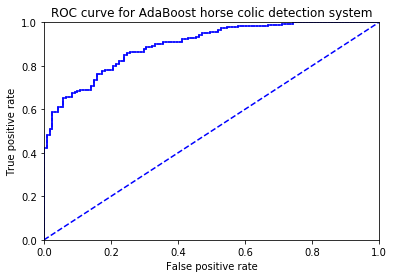

the Area Under the Curve is:  0.8953941870182941


In [4]:
dataArr, labelArr = loadDataSet('horseColicTraining2.txt')
classifierArray, aggClassEst = adaBoostTrainDS(dataArr, labelArr, 50)
plotROC(aggClassEst.T , labelArr)

In [5]:
import pandas as pd
import numpy as np

In [6]:
def loadData(filename):
    data = pd.read_csv(filename, sep='\s', header=None, engine='python')
    X = data.iloc[:,[0, 1]]
    Y = data.iloc[:, 2]
    return X, Y

In [7]:
X_train, Y_train = loadData('hw2_adaboost_train.dat')
X_test, Y_test = loadData('hw2_adaboost_test.dat')

In [8]:
def decision_stump(x, sep, s, dim):
    return s * np.where(x[:, dim] >= sep, 1, -1)

def error(yhat, y):
    return (yhat != y).sum() / len(y)

In [133]:
import ipdb

In [146]:
def find_best_stump(D, X, Y):
    feature0 = X[:, 0]
    feature1 = X[:, 1]
    min_error = np.inf
    bestStump = {}
    for s in [1, -1]:
        for i in feature0:
            error = np.where(Y * decision_stump(X, i, s, 0) == -1, 1, 0).dot(D)
            if error < min_error:
                min_error = error
                dim = 0
                sep = i
                min_s = s
        for i in feature1:
            error = np.where(Y * decision_stump(X, i, s, 1) == -1, 1, 0).dot(D)
            if error < min_error:
                min_error = error
                dim = 1
                sep = i
                min_s = s
    bestStump['dim'] = dim
    bestStump['s'] = min_s
    bestStump['sep'] = sep
    return bestStump, min_error[0], decision_stump(X, sep, min_s, dim).copy()

In [169]:
def test(X, Y, classifier):
    X = np.array(X)
    Y = list(Y)
    m, n = X.shape
    aggClassEst = mat(zeros((m,)))
    for i in np.arange(len(classifier)):
        print("eout %d = " % (i + 1))
        classEst = decision_stump(X, classifier[i]['sep'], classifier[i]['s'], classifier[i]['dim'])
        aggClassEst += classifier[i]['alpha'] * classEst
        error_rate = (sign(aggClassEst) != np.mat(Y)).sum() / len(Y)
        print(error_rate)

In [157]:
def adaboost(X, Y, iters=300):
    X = np.array(X)
    Y = list(Y)
    m, n = X.shape
    D = np.ones((m, 1)) / m
    stumps = []
    aggClassEst = mat(zeros((m,)))
    min_et = np.inf
    for iteration in np.arange(iters):
        bestStump, error, classEst = find_best_stump(D, X, Y)
        if error < min_et:
            min_et = error
        t = np.sqrt((1.0-error) / max(error,1e-18))
        alpha = float(log(t)) 
        bestStump['alpha'] = alpha
        stumps.append(bestStump.copy())
        expon = multiply(-1*alpha*mat(Y).T,classEst)
        D[classEst == Y] /= t
        D[classEst != Y] *= t
        print("iter %d\tD=" % iteration, D.sum())
        D = D / D.sum()
        #ipdb.set_trace()
        aggClassEst += alpha * classEst
        error_rate = (sign(aggClassEst) != np.mat(Y)).sum() / len(Y)
        print('total error', error_rate)
        if (error_rate == 0):
            break
    print(min_et)
    return stumps, aggClassEst

In [159]:
classifier, predict = adaboost(X_train, Y_train)

iter 0	D= 0.8541662601625051
total error 0.24
iter 1	D= 0.7662489076189332
total error 0.25
iter 2	D= 0.8486832041667455
total error 0.11
iter 3	D= 0.8708283211210699
total error 0.12
iter 4	D= 0.8530577229065675
total error 0.08
iter 5	D= 0.941076916931044
total error 0.11
iter 6	D= 0.9501560575599906
total error 0.06
iter 7	D= 0.9652768065896885
total error 0.08
iter 8	D= 0.9426472918347097
total error 0.06
iter 9	D= 0.968179428646662
total error 0.06
iter 10	D= 0.9652864463610318
total error 0.05
iter 11	D= 0.9698435589613207
total error 0.06
iter 12	D= 0.9738427920306517
total error 0.05
iter 13	D= 0.9808447507264922
total error 0.06
iter 14	D= 0.966562117475092
total error 0.05
iter 15	D= 0.9789509244552494
total error 0.06
iter 16	D= 0.9670014055765939
total error 0.03
iter 17	D= 0.9771467540666012
total error 0.06
iter 18	D= 0.9684758484676744
total error 0.03
iter 19	D= 0.9769284228953935
total error 0.05
iter 20	D= 0.9704683522166718
total error 0.03
iter 21	D= 0.9784185422544

In [171]:
test(X_test, Y_test, classifier)

eout 1 = 
0.29
eout 2 = 
0.265
eout 3 = 
0.176
eout 4 = 
0.175
eout 5 = 
0.159
eout 6 = 
0.176
eout 7 = 
0.132
eout 8 = 
0.159
eout 9 = 
0.132
eout 10 = 
0.132
eout 11 = 
0.119
eout 12 = 
0.132
eout 13 = 
0.119
eout 14 = 
0.132
eout 15 = 
0.122
eout 16 = 
0.135
eout 17 = 
0.106
eout 18 = 
0.138
eout 19 = 
0.098
eout 20 = 
0.114
eout 21 = 
0.098
eout 22 = 
0.098
eout 23 = 
0.098
eout 24 = 
0.098
eout 25 = 
0.098
eout 26 = 
0.114
eout 27 = 
0.098
eout 28 = 
0.111
eout 29 = 
0.105
eout 30 = 
0.105
eout 31 = 
0.105
eout 32 = 
0.098
eout 33 = 
0.105
eout 34 = 
0.098
eout 35 = 
0.112
eout 36 = 
0.104
eout 37 = 
0.105
eout 38 = 
0.105
eout 39 = 
0.105
eout 40 = 
0.112
eout 41 = 
0.105
eout 42 = 
0.105
eout 43 = 
0.112
eout 44 = 
0.098
eout 45 = 
0.112
eout 46 = 
0.098
eout 47 = 
0.112
eout 48 = 
0.098
eout 49 = 
0.112
eout 50 = 
0.098
eout 51 = 
0.112
eout 52 = 
0.098
eout 53 = 
0.123
eout 54 = 
0.105
eout 55 = 
0.115
eout 56 = 
0.105
eout 57 = 
0.115
eout 58 = 
0.106
eout 59 = 
0.115
eout 60